In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
import main
import visuals
import seaborn as sns
import chromedriver_autoinstaller
from datetime import datetime
import json

## Pull Data
- Read in data however you do so

In [83]:
# Match dataframe containing info about the match
matches_df = pd.read_csv('matches_df.csv', index_col=0)
match_data = json.load(open("match_data.txt"))

# Events dataframe      
events_df = pd.read_csv('events_df.csv', index_col=0)

# match Id
matchId = match_data['matchId']

# Information about respective teams as dictionary
home_data = eval(matches_df['home'][matchId])
away_data = eval(matches_df['away'][matchId])

home_name = home_data['name']
away_name = away_data['name']
date = match_data['startDate'].split('T')[0]
date_ = datetime.strptime(date, '%Y-%m-%d').date()
date_str = date_.strftime('%b %d %Y')

## To Change:
- Depends on whether you want home/away team. Pretty simple either way.
- Currently for home team - if you want the home team, change nothing. 
- For the Away team change (1) id1 to id2 in the Keep T1 Players section and (2) change home <--> away teams in title and (3) change home > away in section Get Shirt Numbers and merge to passes df 

## Filter data to get passes
- Whoscored doesn't have pass recipient - so need to add automatically
- Just shift index by one
- Also have instances where pass is successful but recipient is to another team (half end/free kicks?) - so make sure team id or recipient and player is the same

In [84]:
events_df["passRecipient"] = events_df['playerName'].shift(-1)
events_df['teamRecipient'] = events_df['teamId'].shift(-1)
column_to_move = events_df.pop("passRecipient")
events_df.insert(26, "passRecipient", column_to_move)
column_to_move = events_df.pop("teamRecipient")
events_df.insert(27, "teamRecipient", column_to_move)

In [85]:
events_df2 = events_df[(events_df['type'] == 'Pass')]

In [86]:
events_df = events_df[(events_df['type'] == 'Pass') & (events_df['outcomeType'] == 'Successful')
                      & (events_df['teamId'] == events_df['teamRecipient']) ]

## Passes between 2 players

In [88]:
passes_df = events_df[['eventId','playerName', 'passRecipient']]
passes_df = passes_df.dropna()

In [89]:
passes_df['pair'] = passes_df['playerName'] + ' ' + passes_df['passRecipient']
passes_df

,eventId,playerName,passRecipient,pair
2,3,Lucas Paquetá,Craig Dawson,Lucas Paquetá Craig Dawson
3,4,Craig Dawson,Tomás Soucek,Craig Dawson Tomás Soucek
22,13,Kieran Tierney,Martin Ødegaard,Kieran Tierney Martin Ødegaard
23,14,Martin Ødegaard,Granit Xhaka,Martin Ødegaard Granit Xhaka
24,15,Granit Xhaka,Gabriel Martinelli,Granit Xhaka Gabriel Martinelli
...,...,...,...,...
1574,659,Vladimír Coufal,Declan Rice,Vladimír Coufal Declan Rice
1577,661,Saïd Benrahma,Pablo Fornals,Saïd Benrahma Pablo Fornals
1589,667,Aaron Cresswell,Thilo Kehrer,Aaron Cresswell Thilo Kehrer
1590,668,Thilo Kehrer,Craig Dawson,Thilo Kehrer Craig Dawson


In [90]:
passes_count = passes_df.groupby(['pair']).count().reset_index()
passes_count = passes_count[['pair', 'eventId']]
passes_count.columns = ['pair', 'passes']
passes_count

,pair,passes
0,Aaron Cresswell Declan Rice,6
1,Aaron Cresswell Lucas Paquetá,6
2,Aaron Cresswell Lukasz Fabianski,3
3,Aaron Cresswell Michail Antonio,2
4,Aaron Cresswell Saïd Benrahma,8
...,...,...
192,William Saliba Granit Xhaka,3
193,William Saliba Kieran Tierney,1
194,William Saliba Martin Ødegaard,11
195,William Saliba Oleksandr Zinchenko,3


## Average position for each player

In [91]:
avg_loc_df = events_df[['teamId', 'playerName', 'x', 'y']]
avg_loc_df = avg_loc_df.groupby(['teamId', 'playerName']).agg({'x':np.mean, 'y':[np.mean, 'count']}).reset_index()
avg_loc_df.columns = ['teamId', 'playerName', 'x','y', 'count']
avg_loc_df

,teamId,playerName,x,y,count
0,13,Aaron Ramsdale,15.035294,54.494118,17
1,13,Ben White,53.467647,20.697059,68
2,13,Bukayo Saka,73.206897,25.265517,29
3,13,Eddie Nketiah,60.557143,51.095238,21
4,13,Fábio Vieira,58.400000,32.900000,1
5,13,Gabriel Magalhães,45.052632,70.942105,95
6,13,Gabriel Martinelli,69.614286,66.128571,21
7,13,Granit Xhaka,56.794444,67.312963,54
8,13,Kieran Tierney,56.872973,84.740541,37
9,13,Martin Ødegaard,61.050877,32.894737,57


## Merge Data  

In [92]:
passes_merge = passes_df.merge(passes_count, on='pair')
passes_merge = passes_merge[['playerName', 'passRecipient', 'passes']]
passes_merge = passes_merge.drop_duplicates().reset_index(drop=True)
passes_merge

,playerName,passRecipient,passes
0,Lucas Paquetá,Craig Dawson,6
1,Craig Dawson,Tomás Soucek,3
2,Kieran Tierney,Martin Ødegaard,1
3,Martin Ødegaard,Granit Xhaka,8
4,Granit Xhaka,Gabriel Martinelli,8
...,...,...,...
192,Gabriel Magalhães,Bukayo Saka,1
193,Lucas Paquetá,Jarrod Bowen,2
194,Jarrod Bowen,Pablo Fornals,1
195,Pablo Fornals,Lucas Paquetá,2


In [93]:
avg_loc_df = avg_loc_df[['playerName', 'x', 'y', 'count']]
pass_map = passes_merge.merge(avg_loc_df, on='playerName')
pass_map.rename({'x':'x_start', 'y':'y_start'}, axis='columns', inplace=True)
pass_map = pass_map.merge(avg_loc_df, left_on = 'passRecipient', right_on='playerName', suffixes = ['', '_end'])
pass_map.rename({'x':'x_end', 'y':'y_end'}, axis='columns', inplace=True)
pass_map = pass_map.drop(['playerName_end', 'count_end'], axis=1)
pass_map = pass_map[pass_map['playerName'] != pass_map['passRecipient']]
pass_map

,playerName,passRecipient,passes,x_start,y_start,count,x_end,y_end
0,Lucas Paquetá,Craig Dawson,6,44.690000,41.565000,40,33.603125,37.99375
1,Thilo Kehrer,Craig Dawson,2,32.348000,62.020000,25,33.603125,37.99375
2,Declan Rice,Craig Dawson,7,42.993023,59.727907,43,33.603125,37.99375
3,Tomás Soucek,Craig Dawson,2,34.687500,26.187500,8,33.603125,37.99375
4,Vladimír Coufal,Craig Dawson,4,40.777143,11.385714,35,33.603125,37.99375
...,...,...,...,...,...,...,...,...
192,Thilo Kehrer,Lukasz Fabianski,4,32.348000,62.020000,25,10.010000,50.40000
193,Vladimír Coufal,Lukasz Fabianski,3,40.777143,11.385714,35,10.010000,50.40000
194,Aaron Cresswell,Lukasz Fabianski,3,44.356667,88.493333,30,10.010000,50.40000
195,Ben White,Fábio Vieira,1,53.467647,20.697059,68,58.400000,32.90000


## Keep T1 Players

In [94]:
id1 = home_data['teamId']
id2 = away_data['teamId']

In [95]:
team1_players = events_df[events_df.teamId == id1].groupby('playerName').agg({'minute': [min, max]}).reset_index()
team1_players = pd.concat([team1_players['playerName'], team1_players['minute']], axis=1)
team1_players['mins_played'] = team1_players['max'] - team1_players['min']
team1_players = team1_players.sort_values('mins_played', ascending=False)
team1_players_names = team1_players.playerName
passes_t1 = pass_map[(pass_map['playerName'].isin(team1_players_names)) & 
                     (pass_map['passRecipient'].isin(team1_players_names))]
team1_players_names_top11 = team1_players.playerName[:11].tolist()
team1_players_names_top11

['Gabriel Magalhães',
 'Granit Xhaka',
 'Thomas Partey',
 'Ben White',
 'William Saliba',
 'Bukayo Saka',
 'Eddie Nketiah',
 'Martin Ødegaard',
 'Aaron Ramsdale',
 'Gabriel Martinelli',
 'Kieran Tierney']

## Top 3 players with most completed passes

In [96]:
comp_passes = passes_t1.groupby('playerName')[['playerName','passes']].sum().reset_index().sort_values(by='passes',
                                                                                        ascending=False)
comp_passes = comp_passes[comp_passes['playerName'].isin(team1_players_names_top11)][:3]
team1_players_names_top11
comp_passes_list = []
for p, passes in zip(comp_passes['playerName'], comp_passes['passes']):
    comp_passes_list.append([p, passes])
comp_passes_list

[['Gabriel Magalhães', 95], ['William Saliba', 93], ['Thomas Partey', 78]]

## Top 3 Combinations

In [97]:
combos = passes_t1.sort_values(by='passes', ascending=False)
combos = combos[(combos['playerName'].isin(team1_players_names_top11)) & (combos['passRecipient'].isin(team1_players_names_top11))]
combos = combos[:3][['playerName', 'passRecipient', 'passes']]
combos_list = []
for p1, p2, cnt in zip(combos['playerName'], combos['passRecipient'], combos['passes']):
    combos_list.append([p1,p2, cnt])
combos_list

[['Gabriel Magalhães', 'William Saliba', 32],
 ['William Saliba', 'Ben White', 28],
 ['William Saliba', 'Gabriel Magalhães', 22]]

## Prog. Pass Field + Top 3 Prog. Passes

In [98]:
prog_passes = events_df[['playerName', 'passRecipient', 'type', 'x', 'y', 'endX', 'endY']]
prog_passes.rename({'x':'x_start', 'y':'y_start', 'endX': 'x_end', 'endY':'y_end'}, axis='columns', inplace=True)
prog_passes = prog_passes[(prog_passes['playerName'].isin(team1_players_names))]
prog_passes = prog_passes.reset_index(drop=True)

prog_passes['Progressive'] = ''
for i in range(len(prog_passes)):
    x_0 = 120*(prog_passes['x_start'][i])/100
    y_0 = 80*(prog_passes['y_start'][i])/100
    x_1 = 120*(prog_passes['x_end'][i])/100
    y_1 = 80*(prog_passes['y_end'][i])/100
    
    beg_dist = np.sqrt((120 - x_0)**2 + (40 - y_0)**2)
    end_dist = np.sqrt((120 - x_1)**2 + (40 - y_1)**2)

    if end_dist/beg_dist <= 0.75:
        prog_passes['Progressive'][i] = 'True'
    else:
        prog_passes['Progressive'][i] = 'False'

        
prog_passes2 = prog_passes[prog_passes['Progressive'] == 'True'].groupby('playerName')['type'].count().sort_values(ascending=False).reset_index()
prog_passes2 = prog_passes2[prog_passes2['playerName'].isin(team1_players_names_top11)][:3]
prog_passes_list = []
for p, cnt in zip(prog_passes2['playerName'], prog_passes2['type']):
    prog_passes_list.append([p,cnt])

prog_received = pd.DataFrame(prog_passes[prog_passes['Progressive'] == 'True'].groupby('passRecipient')['type'].count().sort_values(ascending=False)).reset_index()
prog_received = prog_received[prog_received['passRecipient'].isin(team1_players_names_top11)][:3]
prog_received_list = []
for p, cnt in zip(prog_received['passRecipient'], prog_received['type']):
    prog_received_list.append([p,cnt])

prog_passes_list

[['Martin Ødegaard', 10], ['Thomas Partey', 9], ['Gabriel Magalhães', 8]]

## Top 3 Pass Completion

In [100]:
events_df2 = events_df2[events_df2['playerName'].isin(team1_players_names_top11)][['playerName','outcomeType']]
pass_comp_df = pd.DataFrame(events_df2.groupby(['playerName', 'outcomeType']).size()).unstack(fill_value=0).stack().reset_index()
pass_comp_df.columns = ['playerName', 'outcome', 'count']
events_df2
pass_comp = []
for i in range(0, len(pass_comp_df), 2):
    rate = pass_comp_df['count'][i] / (pass_comp_df['count'][i]+pass_comp_df['count'][i+1])
    pass_comp.append([pass_comp_df['playerName'][i], rate])

pass_comp.sort(key=lambda x:x[1], reverse=True)
pass_comp = pass_comp[0:3]
for i, val in enumerate(pass_comp):
    val[1] = round(float(val[1])*100)
pass_comp
    
    

[['William Saliba', 96], ['Granit Xhaka', 93], ['Gabriel Magalhães', 92]]

## Top 3 xThreat via Pass

In [101]:
events_df_xT = events_df[['playerName', 'x', 'y', 'endX', 'endY']].reset_index(drop=True)

xT_list = []
xT = pd.read_csv("xT_grid.csv", header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

for name in team1_players_names_top11:
    test = events_df_xT[events_df_xT['playerName'] == name]
    test['x1_bin'] = pd.cut(test['x'], bins=xT_cols, labels=False)
    test['x2_bin'] = pd.cut(test['endX'], bins=xT_cols, labels=False)
    test['y1_bin'] = pd.cut(test['y'], bins=xT_rows, labels=False)
    test['y2_bin'] = pd.cut(test['endY'], bins=xT_rows, labels=False)
    test['xT_start'] = test[['x1_bin', 'y1_bin']].apply(lambda x:xT[x[1]][x[0]], axis=1)
    test['xT_end'] = test[['x2_bin', 'y2_bin']].apply(lambda x:xT[x[1]][x[0]], axis=1)
    test['xT_diff'] = test['xT_end'] - test['xT_start']
    xT_added = test['xT_diff'].sum()
    
    xT_list.append([name, xT_added])
    
xT_list.sort(key=lambda x:x[1], reverse=True)
xT_list2 = xT_list.copy()
xT_list = xT_list[:3]
for i, val in enumerate(xT_list):
    val[1] = round(float(val[1]),2)
xT_list2

[['Ben White', 0.27],
 ['Bukayo Saka', 0.17],
 ['Gabriel Magalhães', 0.16],
 ['Aaron Ramsdale', 0.013572539999999992],
 ['Eddie Nketiah', -0.060883169999999986],
 ['Martin Ødegaard', -0.20871143999999991],
 ['Gabriel Martinelli', -0.23975197999999998],
 ['William Saliba', -0.24852183000000003],
 ['Kieran Tierney', -0.66158711],
 ['Thomas Partey', -1.2904705200000002],
 ['Granit Xhaka', -1.4589555599999997]]

In [102]:
events_df_xT = events_df[['playerName', 'x', 'y', 'endX', 'endY']].reset_index(drop=True)

xT_list = []
path = "https://karun.in/blog/data/open_xt_12x8_v1.json"
xT_grid = pd.read_json(path)
xT_grid = np.array(xT_grid)
xT_grid
xT_rows, xT_cols = xT.shape

for name in team1_players_names_top11:
    test = events_df_xT[events_df_xT['playerName'] == name]
    test['x1_bin'] = pd.cut(test['x'], bins=xT_cols, labels=False)
    test['x2_bin'] = pd.cut(test['endX'], bins=xT_cols, labels=False)
    test['y1_bin'] = pd.cut(test['y'], bins=xT_rows, labels=False)
    test['y2_bin'] = pd.cut(test['endY'], bins=xT_rows, labels=False)
    test['xT_start'] = test[['x1_bin', 'y1_bin']].apply(lambda x:xT[x[1]][x[0]], axis=1)
    test['xT_end'] = test[['x2_bin', 'y2_bin']].apply(lambda x:xT[x[1]][x[0]], axis=1)
    test['xT_diff'] = test['xT_end'] - test['xT_start']
    xT_added = test['xT_diff'].sum()
    
    xT_list.append([name, xT_added])
    
xT_list.sort(key=lambda x:x[1], reverse=True)
xT_list2 = xT_list.copy()
xT_list = xT_list[:3]
for i, val in enumerate(xT_list):
    val[1] = round(float(val[1]),2)
xT_list

[['Ben White', 0.27], ['Bukayo Saka', 0.17], ['Gabriel Magalhães', 0.16]]

In [103]:
xT_scaled = []
minXT = abs(min(xT_list2, key=lambda x:x[1])[1])
for player, xT in xT_list2:
    xT_updated = xT + minXT + 0.05
    xT_scaled.append([player, xT_updated])
df_xT = pd.DataFrame(xT_scaled, columns=['playerName', 'xThreat'])
df_xT

,playerName,xThreat
0,Ben White,1.778956
1,Bukayo Saka,1.678956
2,Gabriel Magalhães,1.668956
3,Aaron Ramsdale,1.522528
4,Eddie Nketiah,1.448072
5,Martin Ødegaard,1.300244
6,Gabriel Martinelli,1.269204
7,William Saliba,1.260434
8,Kieran Tierney,0.847368
9,Thomas Partey,0.218485


## Keep 11 players with most mins

In [104]:
# Get line width and just count instances of 4/more passes
team1_players_names = team1_players.playerName[:11].tolist()
passes_t1 = pass_map[(pass_map['playerName'].isin(team1_players_names)) & 
                     (pass_map['passRecipient'].isin(team1_players_names))]
passes_t1['width'] = passes_t1['passes']/passes_t1['passes'].max() * 12
passes_t1

,playerName,passRecipient,passes,x_start,y_start,count,x_end,y_end,width
78,Kieran Tierney,Martin Ødegaard,1,56.872973,84.740541,37,61.050877,32.894737,0.375
79,Granit Xhaka,Martin Ødegaard,4,56.794444,67.312963,54,61.050877,32.894737,1.500
80,Gabriel Magalhães,Martin Ødegaard,3,45.052632,70.942105,95,61.050877,32.894737,1.125
81,Thomas Partey,Martin Ødegaard,19,52.408974,46.253846,78,61.050877,32.894737,7.125
82,William Saliba,Martin Ødegaard,11,35.298925,41.882796,93,61.050877,32.894737,4.125
...,...,...,...,...,...,...,...,...,...
177,Thomas Partey,Kieran Tierney,5,52.408974,46.253846,78,56.872973,84.740541,1.875
178,William Saliba,Kieran Tierney,1,35.298925,41.882796,93,56.872973,84.740541,0.375
179,Ben White,Kieran Tierney,2,53.467647,20.697059,68,56.872973,84.740541,0.750
180,Bukayo Saka,Kieran Tierney,1,73.206897,25.265517,29,56.872973,84.740541,0.375


In [105]:
# Set marker size and keep over 4 passes
# passes_t1 = passes_t1[passes_t1['passes']>=2]
passes_t1['passes'][passes_t1['passes']<3] = 0
passes_t1['marker_size'] = (passes_t1['count']
                                         / passes_t1['count'].max() * 2500)
passes_t1

,playerName,passRecipient,passes,x_start,y_start,count,x_end,y_end,width,marker_size
78,Kieran Tierney,Martin Ødegaard,0,56.872973,84.740541,37,61.050877,32.894737,0.375,973.684211
79,Granit Xhaka,Martin Ødegaard,4,56.794444,67.312963,54,61.050877,32.894737,1.500,1421.052632
80,Gabriel Magalhães,Martin Ødegaard,3,45.052632,70.942105,95,61.050877,32.894737,1.125,2500.000000
81,Thomas Partey,Martin Ødegaard,19,52.408974,46.253846,78,61.050877,32.894737,7.125,2052.631579
82,William Saliba,Martin Ødegaard,11,35.298925,41.882796,93,61.050877,32.894737,4.125,2447.368421
...,...,...,...,...,...,...,...,...,...,...
177,Thomas Partey,Kieran Tierney,5,52.408974,46.253846,78,56.872973,84.740541,1.875,2052.631579
178,William Saliba,Kieran Tierney,0,35.298925,41.882796,93,56.872973,84.740541,0.375,2447.368421
179,Ben White,Kieran Tierney,0,53.467647,20.697059,68,56.872973,84.740541,0.750,1789.473684
180,Bukayo Saka,Kieran Tierney,0,73.206897,25.265517,29,56.872973,84.740541,0.375,763.157895


In [106]:
passes_t1 = passes_t1.merge(df_xT, on='playerName')
passes_t1

,playerName,passRecipient,passes,x_start,y_start,count,x_end,y_end,width,marker_size,xThreat
0,Kieran Tierney,Martin Ødegaard,0,56.872973,84.740541,37,61.050877,32.894737,0.375,973.684211,0.847368
1,Kieran Tierney,Gabriel Magalhães,15,56.872973,84.740541,37,45.052632,70.942105,5.625,973.684211,0.847368
2,Kieran Tierney,Granit Xhaka,7,56.872973,84.740541,37,56.794444,67.312963,2.625,973.684211,0.847368
3,Kieran Tierney,Gabriel Martinelli,5,56.872973,84.740541,37,69.614286,66.128571,1.875,973.684211,0.847368
4,Kieran Tierney,Aaron Ramsdale,0,56.872973,84.740541,37,15.035294,54.494118,0.750,973.684211,0.847368
...,...,...,...,...,...,...,...,...,...,...,...
90,Aaron Ramsdale,Gabriel Magalhães,4,15.035294,54.494118,17,45.052632,70.942105,1.500,447.368421,1.522528
91,Aaron Ramsdale,Granit Xhaka,0,15.035294,54.494118,17,56.794444,67.312963,0.375,447.368421,1.522528
92,Aaron Ramsdale,Eddie Nketiah,0,15.035294,54.494118,17,60.557143,51.095238,0.375,447.368421,1.522528
93,Aaron Ramsdale,Thomas Partey,6,15.035294,54.494118,17,52.408974,46.253846,2.250,447.368421,1.522528


## Get Shirt Numbers and merge to passes df 

In [107]:
shirt_nos = home_data['formations'][0]['jerseyNumbers']
playerIds = home_data['formations'][0]['playerIds']
shirt_nos = pd.DataFrame({'no':shirt_nos, 'playerId':playerIds})
playerIds = events_df[['playerId', 'playerName']]
passes_t1 = passes_t1.merge(playerIds, on='playerName')
# shirt_nos['playerId'] = shirt_nos['playerId'].astype(str)
passes_t1 = passes_t1.merge(shirt_nos, on='playerId')
passes_t1 = passes_t1.drop_duplicates().reset_index(drop=True)

## Plot Passing Network

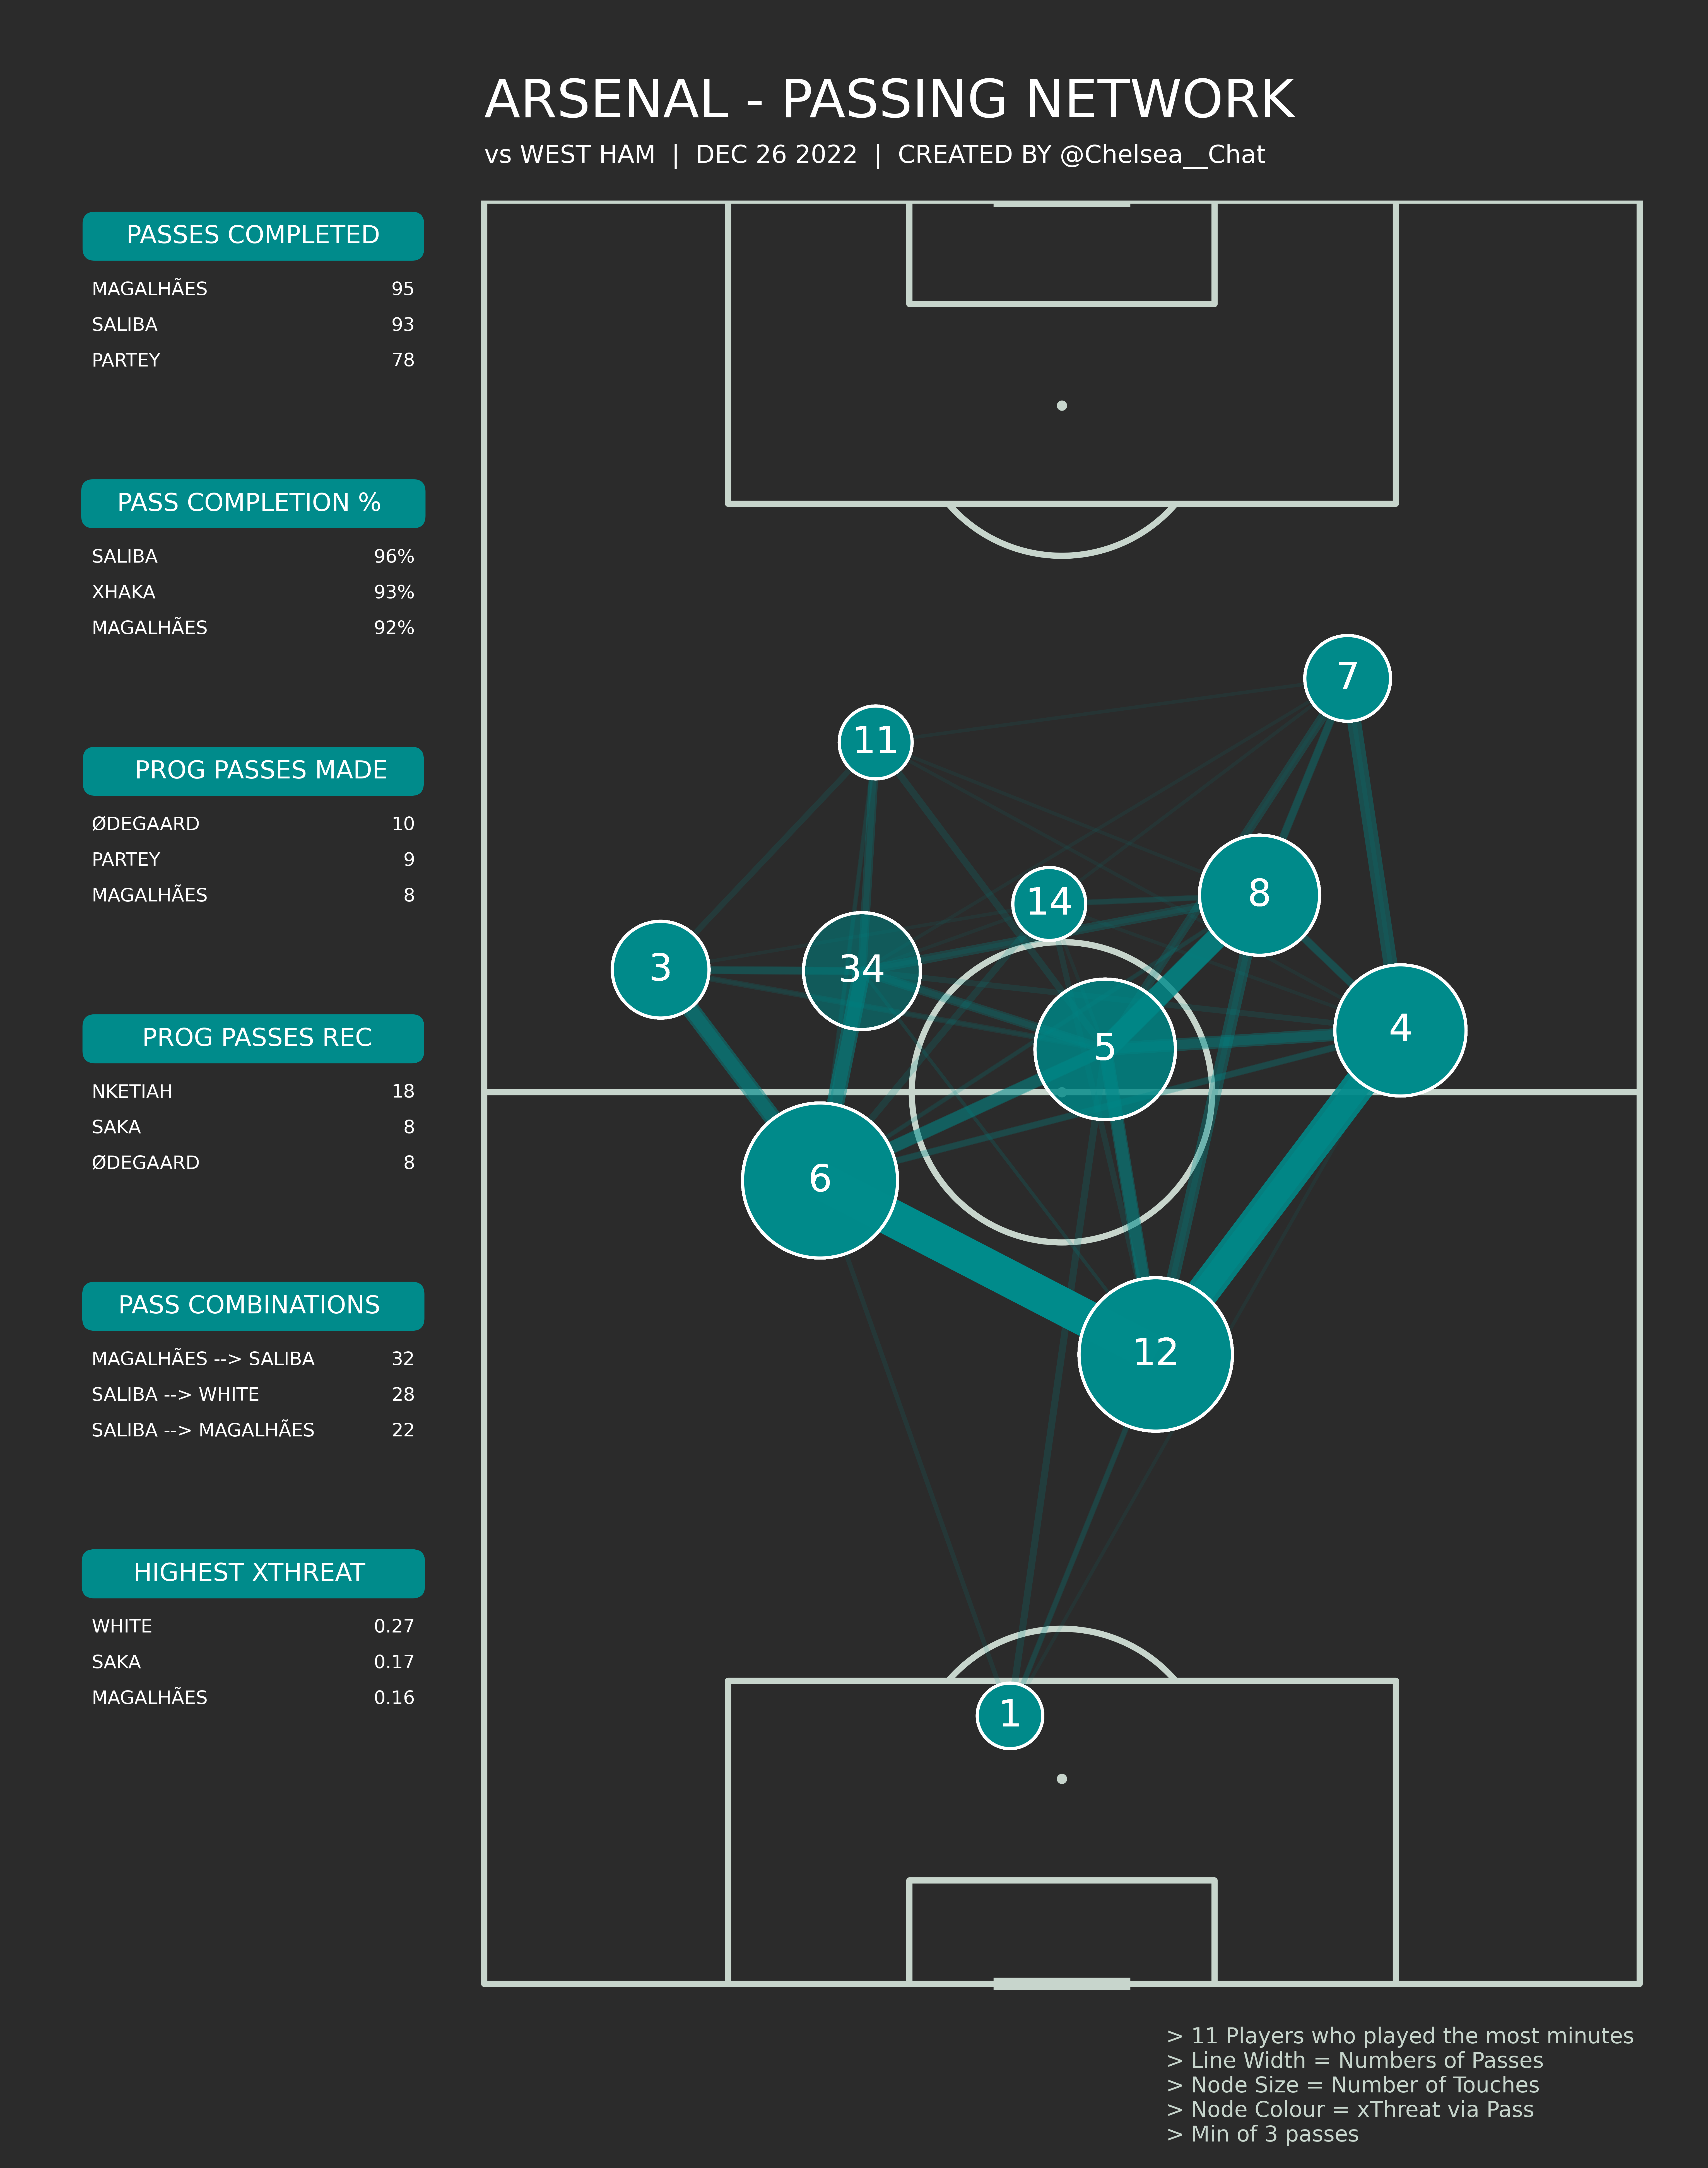

In [108]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from matplotlib.colors import to_rgba
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 800

MIN_TRANSPARENCY = 0.
color = np.array(to_rgba('darkcyan'))
color = np.tile(color, (len(passes_t1), 1))
c_transparency = passes_t1.passes / (passes_t1.passes.max())
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

MIN_TRANSPARENCY2 = 0.05
color2 = np.array(to_rgba('darkcyan'))
color2 = np.tile(color2, (len(passes_t1), 1))
c_transparency2 = (passes_t1.xThreat/ (passes_t1.xThreat.max()))
c_transparency2 = (c_transparency2 * (1 - MIN_TRANSPARENCY2)) + MIN_TRANSPARENCY2
color2[:, 3] = c_transparency2


pitch = VerticalPitch(pitch_type='opta', pitch_color='#2B2B2B', line_color='#c7d5cc',pad_top=0, pad_left = 40)
fig, axs = pitch.grid(figheight=10, title_height=0.08, endnote_space=0, axis=False, 
                      title_space=0, grid_height=0.82, endnote_height=0.05)

fig.set_facecolor("#2B2B2B")

# rectangle1 = plt.Rectangle((0, 0),110,100, color='darkcyan')
# plt.gca().add_patch(rectangle1, ax=axs['left'])

axs['pitch'].annotate(text='    Passes Completed    '.upper(), xytext=(120, 98), xy=(60, 40), ha='center', 
                     va='center', color='white',
                     bbox=dict(facecolor='darkcyan', edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8)

y = 95
i = 0
for p1, cnt in comp_passes_list:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    axs['pitch'].annotate(text=p1.upper(), 
                          xytext=(134, y - 2*i), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    axs['pitch'].annotate(text=cnt, 
                          xytext=(106, y - 2*i), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    
    i += 1
axs['pitch'].annotate(text='   Pass Completion %    '.upper(), xytext=(120, 83), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor='darkcyan', edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8)
y = 80
i = 0
for p1, cnt in pass_comp:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    axs['pitch'].annotate(text=p1.upper(), 
                          xytext=(134, y - 2*i), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    axs['pitch'].annotate(text=str(cnt)+'%', 
                          xytext=(106, y - 2*i), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    
    i += 1



axs['pitch'].annotate(text='     Prog Passes Made   '.upper(), xytext=(120, 68), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor='darkcyan', edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8)
y = 65
i = 0
for p1, cnt in prog_passes_list:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    axs['pitch'].annotate(text=p1.upper(), 
                          xytext=(134, y - 2*i), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    axs['pitch'].annotate(text=cnt, 
                          xytext=(106, y - 2*i), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    
    i += 1

axs['pitch'].annotate(text='      Prog Passes Rec     '.upper(), xytext=(120, 53), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor='darkcyan', edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8)
y = 50
i = 0
for p1, cnt in prog_received_list:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    axs['pitch'].annotate(text=p1.upper(), 
                          xytext=(134, y - 2*i), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    axs['pitch'].annotate(text=cnt, 
                          xytext=(106, y - 2*i), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    
    i += 1


axs['pitch'].annotate(text='   Pass Combinations    '.upper(), xytext=(120, 38), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor='darkcyan', edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8)
y = 35
i = 0
for p1, p2, cnt in combos_list:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
        
    p2 = p2.replace('-', ' ')
    p2 = p2.split(' ')
    if len(p2) > 2:
        name = "".join([x[0].upper() for x in p2])
        p2 = name
    elif len(p2) == 1:
        p2 = p2[0]
    else:
        p2 = p2[1]

    axs['pitch'].annotate(text=p1.upper() + ' --> ' + p2.upper(), 
                          xytext=(134, y - 2*i), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    axs['pitch'].annotate(text=cnt, 
                          xytext=(106, y - 2*i), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    
    i += 1

axs['pitch'].annotate(text='     Highest xThreat      '.upper(), xytext=(120, 23), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor='darkcyan', edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8)

y = 20
i = 0
for p1, cnt in xT_list:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
        
    axs['pitch'].annotate(text=p1.upper(), 
                          xytext=(134, y - 2*i), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    axs['pitch'].annotate(text=str(cnt), 
                          xytext=(106, y - 2*i), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    
    i += 1


# pass_arrows = pitch.arrows(passes_t1.x_start-1, passes_t1.y_start-1,
#                          passes_t1.x_end-1, passes_t1.y_end-1, lw=passes_t1.width,
#                          color=color, zorder=1, ax=axs['pitch'], headlength=6, 
#                          headwidth=4, headaxislength=3)

pass_lines = pitch.lines(passes_t1.x_start, passes_t1.y_start,
                         passes_t1.x_end, passes_t1.y_end, lw=passes_t1.width,
                         color=color, zorder=1, ax=axs['pitch'])


pass_nodes = pitch.scatter(passes_t1.x_start, passes_t1.y_start, s=passes_t1.marker_size,
                           color=color2, edgecolors='white', linewidth=1, ax=axs['pitch'])

for index, row in passes_t1.iterrows():
    pitch.annotate(row.no, xy=(row.x_start, row.y_start), color='white', va='center',
                   ha='center', size=12, ax=axs['pitch'], fontname='Sans Serif')
    
    
axs['title'].text(0, 0.55, home_name.upper() + ' - Passing Network'.upper(), color='White',
                  va='center', ha='left', fontsize=17, fontname='Sans Serif')
axs['title'].text(0, 0.25, 'vs ' + away_name.upper() + '  |  ' + date_str.upper() + '  |  CREATED BY @Chelsea__Chat' , 
                  color='White',
                  va='center', ha='left', fontsize=8)
    

axs['endnote'].set_xlim(0, 1)
axs['endnote'].set_ylim(0, 1)

axs['endnote'].text(0.59, 0.5, '> 11 Players who played the most minutes \n> Line Width = Numbers of Passes \n> Node Size = Number of Touches \n> Node Colour = xThreat via Pass \n> Min of 3 passes' , color='#c7d5cc',
                    va='center', ha='left', fontsize=7, fontname = 'Sans Serif')


fig.savefig('passNetwork.png', dpi=900)

plt.show()
